In [303]:
# Les imports sont préparé ici
# n'enlevez pas les % car il permettent le reload de modules ou l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import pickle as pkl
import re
import matplotlib.pyplot as plt
import platform
from sklearn.metrics import f1_score
import spacy
from spacy import displacy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prétraitement

## Fonction de lecture de fichier

In [304]:
#reading files
#Méthode qui renvoie un tableau contenant les lignes des consensus uniquement 
def readingfile(file):
    if platform.system() == 'Windows':
        f1 = open(file, "r", encoding = "UTF-8")
    else:
        f1 = open(file, "r")

    data_ = []
    data_cons = []
    Y = []
    Y_One_Hot = []

    rows = f1.readlines()
    labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
    for line in rows:   #on itère sur les lignes

            #line.decode("utf-8")
        en_tete=line.split(')')[0]                                      #On récupère seulement l'en_tete de chaque ligne
        
        
        if "consensus" in en_tete:                                        #On vérifie que cet entete contient le consensus
            data_.append(line.split(') ')[1])                                          #si on a consensus dans la ligne courante on l'ajoute au tableau de renvoie
            data_cons.append(line)
            
            if(en_tete[6:9] == "pos"):
                #labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
                Y.append(labels["pos"])
                Y_One_Hot.append([1,0,0,0])
                
            elif(en_tete[6:9] == "neg"):
                #labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
                Y.append(labels["neg"])
                Y_One_Hot.append([0,1,0,0])
                
            elif(en_tete[6:9] == "neu"):
                #labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
                Y.append(labels["neu"])
                Y_One_Hot.append([0,0,1,0])
                
            else:
                #labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
                Y.append(labels["irr"])
                Y_One_Hot.append([0,0,0,1])
            
            
            
    # closing files
    f1.close()

    return data_, data_cons, Y_One_Hot, Y


In [305]:
file = "train_label_temp3.txt"
data_, datacons,Y_one_hot,Y = readingfile(file)


## Tokenisation

In [306]:
from spacy.tokens import Doc
nlp_en = spacy.load("en_core_web_sm")
#nlp_fr = spacy.load("fr_core_news_sm")

# Fonction de tokenization
def tokenizer(data):
    list_doc = []

    for i in data :
        doc = nlp_en(i)
        list_doc.append(doc)


    c_doc = Doc.from_docs(list_doc)
    
    return list_doc, c_doc
    
#affichage de c_doc version jolie 
#displacy.render(c_doc,style = 'ent')


## StopWords et Lemmatisation

In [307]:
from spacy.lang.en.stop_words import STOP_WORDS

# Fonction stopWord qui retire les mots inutiles et ponctuation
# Ainsi que la lemmatisation 

def stopWord_lemma(list_doc):
    list_token=[]

    for line in list_doc:
        filtered = [token.text for token in line if token.is_stop == False]
        tokens = [token.lemma_ for token in line]
        list_token.append(tokens)        
        
    return list_token

## Application du prétraitement sur nos données

In [276]:
# Tokenization des données
c_doc, spacy_doc = tokenizer(data)


In [308]:
#Nettoyage des données --> on enlève les mots inutiles + lemmastisation
doc_filtered = stopWord_lemma(c_doc)

## Création du dictionnaire

In [309]:
def create_dico(doc):
    i = 0
    tokenWord = {}
    tokenValues = {}
    
    for line in doc:   #on itère sur les lignes
        #construction des dicos
        for word in line:
            if word not in tokenWord:
                tokenWord[word] = i
                tokenValues[i] = word
                i+=1
    return tokenWord, tokenValues
        

In [310]:
#Création de nos dictionnaires
dicoWord, dicoValues = create_dico(doc_filtered)

## Tokenisation de nos données en valeurs chiffrées

In [311]:
def tokenization_n(data_, dico):
    data_tokenized = []
    
    for line in data_: 
        temp_list =[]
        for j,word in enumerate(line):
            if word in dico:
                temp_list.append(dico.get(word))
                    
        data_tokenized.append(temp_list)
    
    
    return data_tokenized

In [312]:
tokenize_list = tokenization_n(doc_filtered, dicoWord)

## Traduction de nos données pour l'embedding

### translation_embedding:
Cette fonction complète les tweets par des -1 pour qu'ils possèdent tous la même taille qui est la taille du tweet le plus long (40 mots dans notre cas)

In [369]:
def translation_embedding(tokenize_list):
    length=[]
    new_list=[]
    tweet_list=[]
    for line in tokenize_list:
        length.append(len(line))
        
    max_tweet = max(length)
    
    for line in tokenize_list:
        new_list.append(line)
        while len(new_list) != max_tweet : 
            new_list.append(-1)
        tweet_list.append(new_list)
    return tweet_list

In [ ]:
embed_data = translation_embedding(tokenize_list)
embed_data[0]

## Création du BagOfWords

In [313]:
def bagOfWords(doc, dico):
    boW = np.zeros([len(doc),len(dico)])
    for ind1,line in enumerate(doc): #parcours des tweet de notre doc
        for ind2,word in enumerate(line): #parcours des mots de la ligne
            boW[ind1,word] = 1
    return boW

In [314]:
bow = bagOfWords(tokenize_list,dicoValues)

# Création du modèle avec Pytorch

In [315]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data


from sklearn.metrics import f1_score
device = 'cuda' if T.cuda.is_available() else 'cpu'

# Specify a path
PATH_MODEL1 = "word_class_model1.pt"
PATH_MODEL2 = "word_class_model2.pt"

In [316]:
class Model1(nn.Module): # pour faire un modèle dans pytorch il faut instancier la classe nn.Module
    def __init__(self, in_dim, out_dim): #Ici, in_dim = 4780 & out_dim = 4
        super(Model1, self).__init__()
        # couche d'entrée (in_dim variables) vers sortie (out_dim neurones)
        self.layer1 = nn.Linear(in_dim, 512)
        self.layer2 = nn.Linear(512, out_dim)
        # initialisation de softmax / fonction d'activation (regroupement de donnée)
    
        self.softmax = nn.LogSoftmax(dim = 1)
        self.relu = nn.ReLU()
        

    def forward(self, inputs):
        #application de la combinaison linéaire au tensor d'entrée
        combLinear1 = self.layer1(inputs)
        #transformation du tensor avec la fonction Softmax
        out1 = self.relu(combLinear1)

        combLinear2 = self.layer2(out1)
        out2 = self.softmax(combLinear2)
        return out2
       
class Model2(nn.Module): # pour faire un modèle dans pytorch il faut instancier la classe nn.Module
    def __init__(self, in_dim, out_dim): #Ici, in_dim = 4780 & out_dim = 4
        super(Model2, self).__init__()
        # couche d'entrée (in_dim variables) vers sortie (out_dim neurones)
        self.layer1 = nn.Linear(in_dim, out_dim)
        # initialisation de softmax / fonction d'activation (regroupement de donnée)
    
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, inputs):
        #application de la combinaison linéaire au tensor d'entrée
        combLinear1 = self.layer1(inputs)
        #transformation du tensor avec la fonction Softmax
        out1 = self.softmax(combLinear1)
        return out1

    
    

    
class Model3(nn.Module): # pour faire un modèle dans pytorch il faut instancier la classe nn.Module
    def __init__(self, in_dim, out_dim): #Ici, in_dim = 4780 & out_dim = 4
        super(Model3, self).__init__()
        # couche d'entrée (in_dim variables) vers sortie (out_dim neurones)
        #self.layer1 = nn.Linear(in_dim, 512)
        #self.layer2 = nn.Linear(512, out_dim)
        
        self.layer1 = nn.Linear(in_dim, 512)
        self.layer2 = nn.Linear(512, out_dim)
        # initialisation de softmax / fonction d'activation (regroupement de donnée)
    
        self.softmax = nn.LogSoftmax(dim = 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        combLinear1 = self.layer1(inputs)
        #transformation du tensor avec la fonction Softmax
        out1 = self.sigmoid(combLinear1)

        combLinear2 = self.layer2(out1)
        out2 = self.softmax(combLinear2)
        return out2

In [317]:
train_X = bow[:1500]
train_Y_onehot = Y_one_hot[:1500]
train_Y = Y[:1500]

valid_X = bow[1500:]
valid_Y_onehot = Y_one_hot[1500:]
valid_Y = Y[1500:]

def affiche(losses, f1_valid):
    plt.plot(np.arange(0,len(losses)),losses)
    plt.title('Evolution fnct de perte train set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(f1_valid, label = 'f1_valid')
    plt.title('Evolution fnct de score de valid et batch')
    plt.xlabel("Epochs")
    plt.ylabel("Score_batch")
    plt.legend()
    plt.show()
        

In [318]:
def collate(batch):
    transposed_data = list(zip(*batch))
    return T.stack(transposed_data[0], 0), T.stack(transposed_data[1], 0)



def train(model,train_X, train_Y, valid_X, valid_Y, epochs=100, batch_size=64, lr = 1e-3):
    
    
    
    opti = T.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss() # Pour calculer la crossentropy, il faut calculer la NLLL après un logsofmax
    
    
    ## Transformation des données pour l'entraînement
    #trn_X = [T.tensor(x, dtype=T.long) for x in train_X]
    #trn_Y = [T.tensor(y, dtype=T.long) for y in train_Y]
    
    #vld_X = [T.tensor(x, dtype=T.long) for x in valid_X]
    #vld_Y = [T.tensor(y, dtype=T.long) for y in valid_Y]
    
    trn_X = T.tensor(train_X, dtype=T.float)
    trn_Y = T.tensor(train_Y, dtype=T.long)
    
    vld_X = T.tensor(valid_X, dtype=T.float)
    vld_Y = T.tensor(valid_Y, dtype=T.long)
    
    train_set = data.TensorDataset(trn_X, trn_Y)
    valid_set = data.TensorDataset(vld_X, vld_Y)
    
    
    ## Creation des loaders
    train_sampler = data.BatchSampler(data.RandomSampler(range(len(train_X))), batch_size, False)
    valid_sampler = data.BatchSampler(data.SequentialSampler(range(len(valid_X))), len(valid_X), False)
    
    train_loader = data.DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate)
    valid_loader = data.DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=collate)
    
    
    losses = []
    f1_valid = []
    
    for e in range(epochs):
        
        model.train() #passe votre modele en phase d'entrainement 
        
        for batch_ndx, (trn_x, trn_y) in enumerate(train_loader):
            opti.zero_grad()
            
            preds = model(trn_x)
            loss = criterion(preds, trn_y)
            losses.append(loss.item())
            loss.backward()
            opti.step()
            
        opti.zero_grad()
        model.eval()
        
        for batch_ndx, (vld_x, vld_y) in enumerate(valid_loader):
            
            preds_val = model(vld_x)
            preds = T.argmax(preds_val, dim=1)
            f1_valid.append(f1_score(vld_y.to('cpu').numpy(), preds.to('cpu').numpy(), average='micro',
                            labels=[i for i in range(4)]))
        print(f"F1 {e}/{epochs}: {f1_valid[-1]}")
    
    return model, losses, f1_valid





In [319]:
model1 = Model1(len(train_X[0]), 4)
model2 = Model2(len(train_X[0]), 4)
model3 = Model3(len(train_X[0]), 4)

model4 = nn.Sequential(
        nn.Linear(len(train_X[0]), 512),
        nn.LeakyReLU(),
        nn.Linear(512, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 4),
        nn.LogSoftmax(dim = 1),
    )

row,col = train_X.shape

model5 = nn.Sequential(
        nn.Embedding(col, 64),
        nn.Linear(len(train_X[0]), 512),
        nn.LeakyReLU(),
        nn.Linear(512, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 4),
        nn.LogSoftmax(dim = 1),
    )



F1 0/20: 0.5748502994011976
F1 1/20: 0.5968063872255489
F1 2/20: 0.6047904191616766
F1 3/20: 0.6487025948103793
F1 4/20: 0.6606786427145709
F1 5/20: 0.6706586826347305
F1 6/20: 0.6766467065868264
F1 7/20: 0.6786427145708582
F1 8/20: 0.6786427145708582
F1 9/20: 0.6926147704590818
F1 10/20: 0.6926147704590818
F1 11/20: 0.6946107784431138
F1 12/20: 0.6866267465069861
F1 13/20: 0.6866267465069861
F1 14/20: 0.6926147704590818
F1 15/20: 0.6966067864271457
F1 16/20: 0.6926147704590818
F1 17/20: 0.6926147704590818
F1 18/20: 0.6926147704590818
F1 19/20: 0.688622754491018


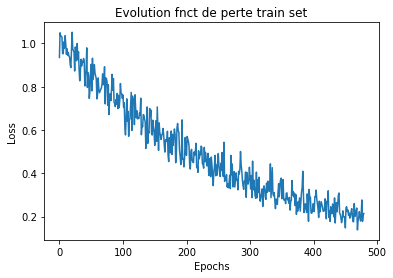

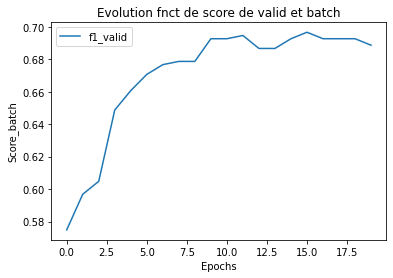

In [330]:
model1, losses_train, f1_valid = train(model1, train_X, train_Y, valid_X, valid_Y, epochs=20, lr=1e-4)
T.save(model1, PATH_MODEL1)

affiche(losses_train, f1_valid)

F1 0/50: 0.6766467065868264
F1 1/50: 0.6786427145708582
F1 2/50: 0.6786427145708582
F1 3/50: 0.6806387225548902
F1 4/50: 0.6806387225548902
F1 5/50: 0.6826347305389222
F1 6/50: 0.6826347305389222
F1 7/50: 0.6846307385229541
F1 8/50: 0.6846307385229541
F1 9/50: 0.6846307385229541
F1 10/50: 0.6846307385229541
F1 11/50: 0.6846307385229541
F1 12/50: 0.6826347305389222
F1 13/50: 0.6826347305389222
F1 14/50: 0.6826347305389222
F1 15/50: 0.6806387225548902
F1 16/50: 0.6806387225548902
F1 17/50: 0.6786427145708582
F1 18/50: 0.6826347305389222
F1 19/50: 0.6826347305389222
F1 20/50: 0.6806387225548902
F1 21/50: 0.6806387225548902
F1 22/50: 0.6806387225548902
F1 23/50: 0.6806387225548902
F1 24/50: 0.6806387225548902
F1 25/50: 0.6806387225548902
F1 26/50: 0.6806387225548902
F1 27/50: 0.6806387225548902
F1 28/50: 0.6806387225548902
F1 29/50: 0.6806387225548902
F1 30/50: 0.6806387225548902
F1 31/50: 0.6806387225548902
F1 32/50: 0.6786427145708582
F1 33/50: 0.6806387225548902
F1 34/50: 0.678642714570

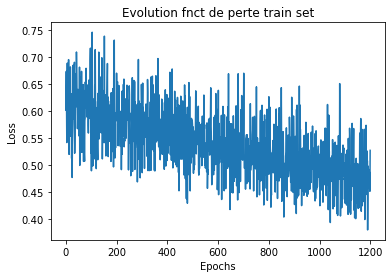

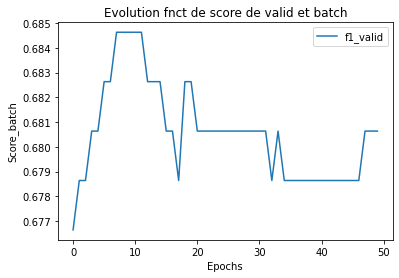

In [333]:
model2, losses_train, f1_valid = train(model2,train_X, train_Y, valid_X, valid_Y, epochs=50, lr=1e-4)
T.save(model2, PATH_MODEL2)

affiche(losses_train, f1_valid)

F1 0/50: 0.4171656686626746
F1 1/50: 0.4171656686626746
F1 2/50: 0.4171656686626746
F1 3/50: 0.4171656686626746
F1 4/50: 0.4231536926147704
F1 5/50: 0.4231536926147704
F1 6/50: 0.4351297405189621
F1 7/50: 0.4351297405189621
F1 8/50: 0.4750499001996008
F1 9/50: 0.5129740518962076
F1 10/50: 0.5049900199600799
F1 11/50: 0.5209580838323353
F1 12/50: 0.5249500998003992
F1 13/50: 0.5608782435129741
F1 14/50: 0.5508982035928144
F1 15/50: 0.5688622754491018
F1 16/50: 0.564870259481038
F1 17/50: 0.5828343313373253
F1 18/50: 0.5748502994011976
F1 19/50: 0.5848303393213573
F1 20/50: 0.592814371257485
F1 21/50: 0.5968063872255489
F1 22/50: 0.6047904191616766
F1 23/50: 0.6007984031936128
F1 24/50: 0.6087824351297405
F1 25/50: 0.6347305389221557
F1 26/50: 0.6167664670658682
F1 27/50: 0.6467065868263473
F1 28/50: 0.6447105788423154
F1 29/50: 0.6506986027944112
F1 30/50: 0.654690618762475
F1 31/50: 0.656686626746507
F1 32/50: 0.6586826347305389
F1 33/50: 0.6666666666666666
F1 34/50: 0.6666666666666666

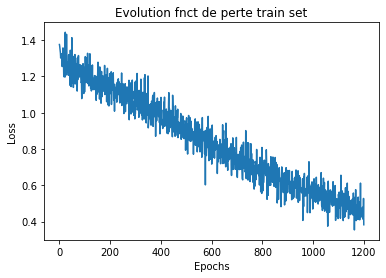

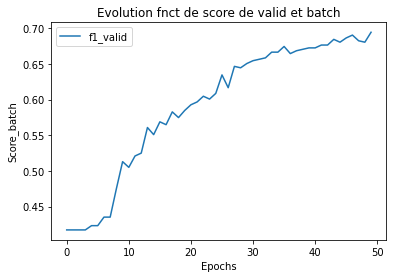

In [334]:
model3, losses_train, f1_valid = train(model3,train_X, train_Y, valid_X, valid_Y, epochs=50, lr=1e-4)
#T.save(model3, PATH_MODEL2)

affiche(losses_train, f1_valid)

F1 0/20: 0.27944111776447106
F1 1/20: 0.5728542914171657
F1 2/20: 0.6147704590818364
F1 3/20: 0.6027944111776448
F1 4/20: 0.6127744510978044
F1 5/20: 0.6287425149700598
F1 6/20: 0.6287425149700598
F1 7/20: 0.6327345309381237
F1 8/20: 0.6347305389221557
F1 9/20: 0.6586826347305389
F1 10/20: 0.6746506986027944
F1 11/20: 0.6626746506986028
F1 12/20: 0.6646706586826348
F1 13/20: 0.6646706586826348
F1 14/20: 0.6586826347305389
F1 15/20: 0.6586826347305389
F1 16/20: 0.654690618762475
F1 17/20: 0.6487025948103793
F1 18/20: 0.6387225548902196
F1 19/20: 0.6447105788423154


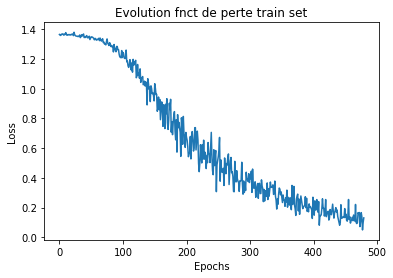

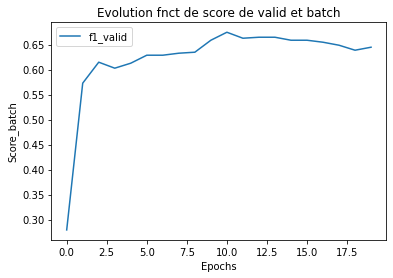

In [335]:
model4, losses_train, f1_valid = train(model4,train_X, train_Y, valid_X, valid_Y, epochs=20, lr=1e-4)
#T.save(model4, PATH_MODEL2)

affiche(losses_train, f1_valid)


In [ ]:
model5, losses_train, f1_valid = train(model4,train_X, train_Y, valid_X, valid_Y, epochs=50, lr=1e-4)
#T.save(model4, PATH_MODEL2)

affiche(losses_train, f1_valid)

In [322]:
model1 = T.load(PATH_MODEL1)
model1.eval()
model2 = T.load(PATH_MODEL2)
model2.eval()

Model2(
  (layer1): Linear(in_features=8653, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [337]:
def reading_new_file(file):
    if platform.system() == 'Windows':
        f1 = open(file, "r", encoding = "UTF-8")
        fread = open(file, "r+", encoding = "UTF-8")
    else:
        f1 = open(file, "r")
        fread = open(file, "r+")
        
    data_ = []

    rows = f1.readlines()
    for line in rows:   #on itère sur les lignes
        en_tete=line.split(')')[0]                                      #On récupère seulement l'en_tete de chaque ligne
                                                                           #On vérifie que cet en_tete contient le consensus
        data_.append(line)                                         #si on a consensus dans la ligne courante on l'ajoute au tableau de renvoie

    

    return data_, fread

In [344]:
def tokenization_nouveaux_tweets(data_, dicoW):
    # Tokenization des données
    c_doc, spacy_doc = tokenizer(data_)
    #Nettoyage des données --> on enlève les mots inutiles + lemmastisation
    doc_filtered = stopWord_lemma(c_doc)
    tokenize_list = tokenization_n(doc_filtered, dicoW)
    return tokenize_list
    

In [345]:
# mettez votre code ici
file_name = "train_nolabel.txt"
formerBow = bow

data_, fread = reading_new_file(file_name)
data_tokenized = tokenization_nouveaux_tweets(data_, dicoWord)


X = bagOfWords(data_tokenized,dicoValues)


In [346]:
def predict(outfile,model,Bow, file_name):
    
    Bow_tensor = T.tensor(Bow, dtype=T.float)
    preds_val = model(Bow_tensor)
    pred = T.argmax(preds_val, dim=1)
    pred_text = []

    
    for res in pred:
        if(res == 0):
            pred_text.append("pos")
        elif(res == 1):
            pred_text.append("neg")
        elif(res == 2):
            pred_text.append("neu")
        elif(res == 3):
            pred_text.append("irr")

            
    rows = outfile.readlines()
    for j,line in enumerate(rows):
        
        listline = list(line)
        listline[6:9]= pred_text[j]
        line = ''.join(listline)
        rows[j] = line

    if platform.system() == 'Windows':
        f1 = open(file_name, "w", encoding = "UTF-8")
    else:
        f1 = open(file_name, "w")
        
    for j,line in enumerate(rows):
        f1.write(line)
        


In [347]:

predict(fread, model2, X, file_name)
fread.close()


# Annexes de prétraitement

In [255]:
#Lemmatization  --> fonction inutilisée
def lemmatization(list_doc):
    
    list_token=[]
    for line in list_doc:
        tokens = [token.lemma_ for token in line]
        list_token.append(tokens)
    return list_token

In [256]:
#Fonction pour transformer doc_lemma et vecteur --> fonction inutilisée
def vectorisation(doc):
    vec = []
    for ind,line in enumerate(doc):   #on itère sur les lignes du doc
        vec.append(line[1])
    return vec

In [257]:
# affichage des mots inutiles 
from spacy.lang.en.stop_words import STOP_WORDS
stop = STOP_WORDS
print(stop)


{'above', 'their', 'has', 'mostly', 'so', 'back', 'itself', 'others', 'thus', 'in', 're', 'namely', 'every', 'below', 'same', 'hence', 'once', 'somehow', "'m", 'amongst', '’re', 'hers', 'no', 'should', '’s', 'made', 'name', 'thereupon', 'could', 'we', 'after', 'most', 'sometimes', 'via', 'they', 'n‘t', 'will', 'ten', 'than', 'did', 'through', 'for', 'further', 'without', 'among', 'four', 'around', 'myself', 'yet', 'another', 'me', 'cannot', 'fifty', 'sixty', 'been', 'about', 'here', 'only', 'n’t', 'well', 'being', 'whereupon', 'alone', 'all', 'three', 'enough', 'again', 'go', 'eleven', 'have', 'due', 'then', 'first', 'hundred', 'forty', "n't", 'anyone', 'whole', 'side', 'else', 'keep', 'besides', 'nobody', 'noone', 'down', 'bottom', 'herein', 'give', 'himself', 'at', 'both', 'but', 'into', 'out', 'full', 'whereby', 'across', 'nevertheless', 'one', 'therefore', 'former', 'had', 'these', 'much', 'everywhere', 'there', 'of', 'until', 'whereas', '‘re', 'that', 'everyone', 'anyhow', 'part',

In [264]:
for token in spacy_doc:
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}".format(
        token.text,
        token.idx,
        token.lemma_,
        token.is_punct,
        token.is_space,
        token.shape_,
        token.pos_,
        token.tag_,
        token.ent_type_
    ))

will	0	will	False	False	xxxx	AUX	MD	
be	5	be	False	False	xx	AUX	VB	
at	8	at	False	False	xx	ADP	IN	
the	11	the	False	False	xxx	DET	DT	
London	15	London	False	False	Xxxxx	PROPN	NNP	GPE
#	22	#	True	False	#	SYM	$	
Microsoft	23	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
Partner	33	Partner	False	False	Xxxxx	PROPN	NNP	ORG
Business	41	Business	False	False	Xxxxx	PROPN	NNP	ORG
Briefing	50	Briefing	False	False	Xxxxx	PROPN	NNP	ORG
tomorrow	59	tomorrow	False	False	xxxx	NOUN	NN	DATE
-	68	-	True	False	-	PUNCT	,	
see	70	see	False	False	xxx	VERB	VB	
some	74	some	False	False	xxxx	PRON	DT	
of	79	of	False	False	xx	ADP	IN	
you	82	you	False	False	xxx	PRON	PRP	
there	86	there	False	False	xxxx	ADV	RB	
:)	92	:)	True	False	:)	PUNCT	:	

	94	
	False	True	
	SPACE	_SP	
Wow!RT	95	Wow!RT	False	False	Xxx!XX	PROPN	NNP	
@fmlopez48	102	@fmlopez48	False	False	@xxxxdd	NOUN	NNS	
#	113	#	True	False	#	NUM	CD	CARDINAL
Microsoft	114	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
trabaja	124	trabaja	False	False	xxxx	NOUN	NN	
en	132	en

encrypts	5233	encrypt	False	False	xxxx	NOUN	NNS	
searches	5242	search	False	False	xxxx	NOUN	NNS	
:	5250	:	True	False	:	PUNCT	:	
http://t.co/q8inLdFy	5252	http://t.co/q8inLdFy	False	False	xxxx://x.xx/xdxxXxXx	PROPN	NNP	
#	5273	#	True	False	#	NOUN	NN	
Google	5274	Google	False	False	Xxxxx	PROPN	NNP	

	5280	
	False	True	
	SPACE	_SP	
Hitting	5281	hit	False	False	Xxxxx	VERB	VBG	
the	5289	the	False	False	xxx	DET	DT	
sack	5293	sack	False	False	xxxx	NOUN	NN	
early	5298	early	False	False	xxxx	ADV	RB	
.	5303	.	True	False	.	PUNCT	.	
G	5305	g	False	False	X	NOUN	NN	
-	5306	-	True	False	-	NOUN	NN	
night	5307	night	False	False	xxxx	NOUN	NN	
#	5313	#	True	False	#	ADP	IN	
twitter	5314	twitter	False	False	xxxx	NOUN	NN	

	5321	
	False	True	
	SPACE	_SP	
@APPLE	5322	@apple	False	False	@XXXX	INTJ	UH	
Wow	5329	wow	False	False	Xxx	INTJ	UH	
@MOTOROLA	5333	@motorola	False	False	@XXXX	ADV	RB	
Just	5343	just	False	False	Xxxx	ADV	RB	
crushed	5348	crush	False	False	xxxx	VERB	VBD	
your	5356	your	False	False	xxxx	PRON

Infinite	8374	Infinite	False	False	Xxxxx	PROPN	NNP	ORG
Digital	8383	Digital	False	False	Xxxxx	PROPN	NNP	ORG
Bookcase	8391	Bookcase	False	False	Xxxxx	PROPN	NNP	ORG
http://t.co/gVbdhLiu	8400	http://t.co/gVbdhLiu	False	False	xxxx://x.xx/xXxxxXxx	PROPN	NNP	
by	8421	by	False	False	xx	ADP	IN	
@MeghanKel	8424	@meghankel	False	False	@XxxxxXxx	X	ADD	ORG

	8434	
	False	True	
	SPACE	_SP	
El	8435	El	False	False	Xx	PROPN	NNP	ORG
dia	8438	dia	False	False	xxx	PROPN	NNP	ORG
de	8442	de	False	False	xx	X	FW	ORG
hoy	8445	hoy	False	False	xxx	PROPN	NNP	ORG
esta	8449	esta	False	False	xxxx	PROPN	NNP	ORG
muy	8454	muy	False	False	xxx	PROPN	NNP	
flojo	8458	flojo	False	False	xxxx	ADP	IN	
el	8464	el	False	False	xx	PROPN	NNP	
#	8467	#	True	False	#	PROPN	NNP	
Twitter	8468	Twitter	False	False	Xxxxx	PROPN	NNP	
qe	8476	qe	False	False	xx	PROPN	NNP	
pasaa	8479	pasaa	False	False	xxxx	NOUN	NN	PERSON
DDDDDDDD	8485	DDDDDDDD	False	False	XXXX	PROPN	NNP	PERSON
:	8493	:	True	False	:	PUNCT	:	
la	8495	la	False	False	xx	DET	DT	
apo

Outlook	10704	Outlook	False	False	Xxxxx	PROPN	NNP	
ConnectorをインストールするとOutlook2007でhotmailアカウントが利用できる→ブラウザを立ち上げなくてもメールを閲覧できる	10712	ConnectorをインストールするとOutlook2007でhotmailアカウントが利用できる→ブラウザを立ち上げなくてもメールを閲覧できる	False	False	XxxxxXxxxxddddxxxx→xxxx	PROPN	NNP	
#	10785	#	True	False	#	X	FW	
Microsoft	10786	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
#	10796	#	True	False	#	X	FW	MONEY
Office	10797	Office	False	False	Xxxxx	PROPN	NNP	MONEY
#	10804	#	True	False	#	NOUN	NN	
Outlook	10805	Outlook	False	False	Xxxxx	PROPN	NNP	

	10812	
	False	True	
	SPACE	_SP	
So	10813	so	False	False	Xx	ADV	RB	
is	10816	be	False	False	xx	AUX	VBZ	
the	10819	the	False	False	xxx	DET	DT	
#	10823	#	True	False	#	NOUN	NN	CARDINAL
galaxynexus	10824	galaxynexus	False	False	xxxx	NOUN	NN	
coming	10836	come	False	False	xxxx	VERB	VBG	
to	10843	to	False	False	xx	AUX	IN	
@sprint	10846	@sprint	False	False	@xxxx	VERB	VB	
any	10854	any	False	False	xxx	DET	DT	
info	10858	info	False	False	xxxx	NOUN	NN	
@android	10863	@android	False	False	@xxxx	PR

worldwide	13871	worldwide	False	False	xxxx	ADV	RB	
in	13881	in	False	False	xx	ADP	IN	
#	13884	#	True	False	#	SYM	$	DATE
twitter	13885	twitter	False	False	xxxx	NOUN	NN	

	13892	
	False	True	
	SPACE	_SP	
RT	13893	RT	False	False	XX	PROPN	NNP	ORG
@adamnash	13896	@adamnash	False	False	@xxxx	PROPN	NNP	ORG
:	13905	:	True	False	:	PUNCT	:	
The	13907	the	False	False	Xxx	DET	DT	
takeaway	13911	takeaway	False	False	xxxx	NOUN	NN	
from	13920	from	False	False	xxxx	ADP	IN	
the	13925	the	False	False	xxx	DET	DT	
@Apple	13929	@apple	False	False	@Xxxxx	NOUN	NN	ORG
earnings	13936	earning	False	False	xxxx	NOUN	NNS	
call	13945	call	False	False	xxxx	NOUN	NN	
?	13949	?	True	False	?	PUNCT	.	
Even	13951	even	False	False	Xxxx	ADV	RB	
Apple	13956	Apple	False	False	Xxxxx	PROPN	NNP	ORG
needs	13962	need	False	False	xxxx	VERB	VBZ	
a	13968	a	False	False	x	DET	DT	
new	13970	new	False	False	xxx	ADJ	JJ	
iPhone	13974	iPhone	False	False	xXxxxx	PROPN	NNP	ORG
release	13981	release	False	False	xxxx	NOUN	NN	
every	13989	every	F

n't	19765	not	False	False	x'x	PART	RB	
have	19769	have	False	False	xxxx	VERB	VB	
a	19774	a	False	False	x	DET	DT	
snippy	19776	snippy	False	False	xxxx	ADJ	JJ	
answer	19783	answer	False	False	xxxx	NOUN	NN	
.	19789	.	True	False	.	PUNCT	.	
Missed	19791	miss	False	False	Xxxxx	VERB	VBN	
opportunity	19798	opportunity	False	False	xxxx	NOUN	NN	
@apple	19810	@apple	False	False	@xxxx	NOUN	NN	

	19816	
	False	True	
	SPACE	_SP	
On	19817	on	False	False	Xx	ADP	IN	
the	19820	the	False	False	xxx	DET	DT	
blog	19824	blog	False	False	xxxx	NOUN	NN	
we	19829	we	False	False	xx	PRON	PRP	
discuss	19832	discuss	False	False	xxxx	VERB	VBP	
#	19840	#	True	False	#	SYM	$	
Microsoft	19841	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
embracing	19851	embracing	False	False	xxxx	NOUN	NN	
of	19861	of	False	False	xx	ADP	IN	
#	19864	#	True	False	#	SYM	$	MONEY
Apache	19865	Apache	False	False	Xxxxx	PROPN	NNP	MONEY
#	19872	#	True	False	#	NOUN	NN	MONEY
Hadoop	19873	Hadoop	False	False	Xxxxx	PROPN	NNP	
for	19880	for	False	False	xxx	

recognition	23386	recognition	False	False	xxxx	NOUN	NN	
is	23398	be	False	False	xx	AUX	VBZ	
absolutely	23401	absolutely	False	False	xxxx	ADV	RB	
a	23412	a	False	False	x	DET	DT	
step	23414	step	False	False	xxxx	NOUN	NN	
above	23419	above	False	False	xxxx	ADP	IN	
previous	23425	previous	False	False	xxxx	ADJ	JJ	
attempts	23434	attempt	False	False	xxxx	NOUN	NNS	
.	23442	.	True	False	.	PUNCT	.	
Bravo	23444	Bravo	False	False	Xxxxx	PROPN	NNP	
@apple	23450	@apple	False	False	@xxxx	NOUN	NN	

	23456	
	False	True	
	SPACE	_SP	
i	23457	I	False	False	x	PRON	PRP	
love	23459	love	False	False	xxxx	VERB	VBP	
#	23464	#	True	False	#	SYM	$	
google	23465	google	False	False	xxxx	PROPN	NNP	

	23471	
	False	True	
	SPACE	_SP	
RT	23472	RT	False	False	XX	PROPN	NNP	ORG
@takashiruru	23475	@takashiruru	False	False	@xxxx	PROPN	NNP	ORG
:	23487	:	True	False	:	PUNCT	:	
android	23489	android	False	False	xxxx	PROPN	NNP	ORG
beam	23497	beam	False	False	xxxx	NOUN	NN	
って何だろう	23502	って何だろう	False	False	xxxx	NOUN	NN	
#	23509	#	Tr

:	26050	:	True	False	:	PUNCT	:	
@_xmas_carroll	26052	@_xmas_carroll	False	False	@_xxxx_xxxx	PROPN	NNP	
Yeah	26067	yeah	False	False	Xxxx	INTJ	UH	
I	26072	I	False	False	X	PRON	PRP	
got	26074	get	False	False	xxx	VERB	VBD	
#	26078	#	True	False	#	SYM	$	CARDINAL
skype	26079	skype	False	False	xxxx	ADJ	JJ	
and	26085	and	False	False	xxx	CCONJ	CC	
#	26089	#	True	False	#	SYM	$	MONEY
google+	26090	google+	False	False	xxxx+	PROPN	NNP	MONEY
and	26098	and	False	False	xxx	CCONJ	CC	MONEY
#	26102	#	True	False	#	NOUN	NNS	
twitter	26103	twitter	False	False	xxxx	NOUN	NN	
so	26111	so	False	False	xx	SCONJ	IN	
who	26114	who	False	False	xxx	PRON	WP	
needs	26118	need	False	False	xxxx	VERB	VBZ	
facebook	26124	facebook	False	False	xxxx	PROPN	NNP	
?	26132	?	True	False	?	PUNCT	.	

	26133	
	False	True	
	SPACE	_SP	
its	26134	its	False	False	xxx	PRON	PRP$	
funny	26138	funny	False	False	xxxx	ADJ	JJ	
how	26144	how	False	False	xxx	SCONJ	WRB	
you	26148	you	False	False	xxx	PRON	PRP	
can	26152	can	False	False	xxx	AUX	MD	
ta

properly	28133	properly	False	False	xxxx	ADV	RB	
would	28142	would	False	False	xxxx	AUX	MD	
be	28148	be	False	False	xx	AUX	VB	
better	28151	well	False	False	xxxx	ADJ	JJR	
.	28157	.	True	False	.	PUNCT	.	

	28158	
	False	True	
	SPACE	_SP	
Siri	28159	Siri	False	False	Xxxx	PROPN	NNP	PERSON
is	28164	be	False	False	xx	AUX	VBZ	
cool	28167	cool	False	False	xxxx	ADJ	JJ	
but	28172	but	False	False	xxx	CCONJ	CC	
more	28176	more	False	False	xxxx	ADV	RBR	
importantly	28181	importantly	False	False	xxxx	ADV	RB	
handy	28193	handy	False	False	xxxx	ADJ	JJ	
and	28199	and	False	False	xxx	CCONJ	CC	
FUNNY	28203	funny	False	False	XXXX	NOUN	NN	
.	28208	.	True	False	.	PUNCT	.	
@Apple	28210	@Apple	False	False	@Xxxxx	PROPN	NNP	
please	28217	please	False	False	xxxx	INTJ	UH	
configure	28224	configure	False	False	xxxx	VERB	VBP	
it	28234	it	False	False	xx	PRON	PRP	
for	28237	for	False	False	xxx	ADP	IN	
Canada	28241	Canada	False	False	Xxxxx	PROPN	NNP	GPE
.	28247	.	True	False	.	PUNCT	.	
What	28249	what	False	False	Xxxx

verschlüsselt	33273	verschlüsselt	False	False	xxxx	NOUN	NN	PERSON
-	33287	-	True	False	-	PUNCT	HYPH	PERSON
http://t.co/SSdxjoWd	33289	http://t.co/ssdxjowd	False	False	xxxx://x.xx/XXxxxxXx	NOUN	NN	PERSON

	33309	
	False	True	
	SPACE	_SP	PERSON
#	33310	#	True	False	#	SYM	$	
microsoft	33311	microsoft	False	False	xxxx	PROPN	NNP	
#	33321	#	True	False	#	ADP	IN	
SBS	33322	SBS	False	False	XXX	PROPN	NNP	
2011	33326	2011	False	False	dddd	NUM	CD	
disabling	33331	disable	False	False	xxxx	VERB	VBG	
third	33341	third	False	False	xxxx	ADJ	JJ	ORDINAL
party	33347	party	False	False	xxxx	NOUN	NN	
software	33353	software	False	False	xxxx	NOUN	NN	
#	33362	#	True	False	#	NOUN	NN	CARDINAL
updates	33363	update	False	False	xxxx	VERB	VBZ	
via	33371	via	False	False	xxx	ADP	IN	
#	33375	#	True	False	#	SYM	$	CARDINAL
gpo	33376	gpo	False	False	xxx	NOUN	NN	

	33379	
	False	True	
	SPACE	_SP	
What	33380	what	False	False	Xxxx	PRON	WP	
's	33384	be	False	False	'x	AUX	VBZ	
up	33387	up	False	False	xx	ADV	RB	
#	33390	#	True	

and	38283	and	False	False	xxx	CCONJ	CC	
seeing	38287	see	False	False	xxxx	VERB	VBG	
what	38294	what	False	False	xxxx	PRON	WP	
happens	38299	happen	False	False	xxxx	VERB	VBZ	
!	38306	!	True	False	!	PUNCT	.	

	38307	
	False	True	
	SPACE	_SP	
So	38308	so	False	False	Xx	ADV	RB	
@apple	38311	@apple	False	False	@xxxx	VERB	VB	
the	38318	the	False	False	xxx	DET	DT	
new	38322	new	False	False	xxx	ADJ	JJ	
iMessage	38326	iMessage	False	False	xXxxxx	PROPN	NNP	ORG
is	38335	be	False	False	xx	AUX	VBZ	
great	38338	great	False	False	xxxx	ADJ	JJ	
and	38344	and	False	False	xxx	CCONJ	CC	
all	38348	all	False	False	xxx	PRON	DT	
,	38351	,	True	False	,	PUNCT	,	
but	38353	but	False	False	xxx	CCONJ	CC	
is	38357	be	False	False	xx	AUX	VBZ	
there	38360	there	False	False	xxxx	PRON	EX	
a	38366	a	False	False	x	DET	DT	
way	38368	way	False	False	xxx	NOUN	NN	
to	38372	to	False	False	xx	PART	TO	
default	38375	default	False	False	xxxx	VERB	VB	
to	38383	to	False	False	xx	ADP	IN	
SMS	38386	sms	False	False	XXX	NOUN	NN	
when	3

surely	40980	surely	False	False	xxxx	ADV	RB	
.	40986	.	True	False	.	PUNCT	.	
#	40988	#	True	False	#	SYM	$	MONEY
AppleSearch	40989	AppleSearch	False	False	XxxxxXxxxx	PROPN	NNP	MONEY
#	41001	#	True	False	#	SYM	$	
AppleCore	41002	AppleCore	False	False	XxxxxXxxx	PROPN	NNP	
#	41012	#	True	False	#	NOUN	NN	ORG
bigapple	41013	bigapple	False	False	xxxx	NOUN	NN	
haha	41022	haha	False	False	xxxx	NOUN	NN	
!	41026	!	True	False	!	PUNCT	.	
Please	41028	please	False	False	Xxxxx	INTJ	UH	
be	41035	be	False	False	xx	AUX	VB	
the	41038	the	False	False	xxx	DET	DT	
latter	41042	latter	False	False	xxxx	ADJ	JJ	

	41048	
	False	True	
	SPACE	_SP	
Need	41049	need	False	False	Xxxx	VERB	VBP	
to	41054	to	False	False	xx	PART	TO	
update	41057	update	False	False	xxxx	VERB	VB	
my	41064	my	False	False	xx	PRON	PRP$	
apps	41067	app	False	False	xxxx	NOUN	NNS	
.	41071	.	True	False	.	PUNCT	.	
):	41073	):	True	False	):	PUNCT	:	
my	41076	my	False	False	xx	PRON	PRP$	
apple	41079	apple	False	False	xxxx	NOUN	NN	
ID	41085	ID	False	

.	44370	.	True	False	.	PUNCT	.	
Yes	44372	yes	False	False	Xxx	INTJ	UH	
,	44375	,	True	False	,	PUNCT	,	
I	44377	I	False	False	X	PRON	PRP	
'm	44378	be	False	False	'x	AUX	VBP	
annoyed	44381	annoyed	False	False	xxxx	ADJ	JJ	
.	44388	.	True	False	.	PUNCT	.	

	44389	
	False	True	
	SPACE	_SP	
#	44390	#	True	False	#	X	LS	CARDINAL
Microsoft	44391	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
store	44401	store	False	False	xxxx	NOUN	NN	
here	44407	here	False	False	xxxx	ADV	RB	
I	44412	I	False	False	X	PRON	PRP	
come	44414	come	False	False	xxxx	VERB	VBP	
to	44419	to	False	False	xx	PART	TO	
spend	44422	spend	False	False	xxxx	VERB	VB	
my	44428	my	False	False	xx	PRON	PRP$	
hard	44431	hard	False	False	xxxx	ADV	RB	
earned	44436	earn	False	False	xxxx	VERB	VBN	
cash	44443	cash	False	False	xxxx	NOUN	NN	
.	44447	.	True	False	.	PUNCT	.	
#	44449	#	True	False	#	SYM	$	CARDINAL
vslive	44450	vslive	False	False	xxxx	ADJ	JJ	

	44456	
	False	True	
	SPACE	_SP	
#	44457	#	True	False	#	X	LS	PERSON
Oomf	44458	Oomf	False	False

#	47370	#	True	False	#	PROPN	NNP	ORG
google	47371	google	False	False	xxxx	PROPN	NNP	

	47377	
	False	True	
	SPACE	_SP	
Se	47378	Se	False	False	Xx	PROPN	NNP	PERSON
dieron	47381	dieron	False	False	xxxx	NOUN	NN	PERSON
cuenta	47388	cuenta	False	False	xxxx	PROPN	NNP	
que	47395	que	False	False	xxx	PROPN	NNP	
si	47399	si	False	False	xx	PROPN	NNP	
ponen	47402	ponen	False	False	xxxx	PROPN	NNP	
la	47408	la	False	False	xx	PROPN	NNP	
T	47411	T	False	False	X	PROPN	NNP	
de	47413	de	False	False	xx	PROPN	NNP	
#	47416	#	True	False	#	X	FW	
Twitter	47417	Twitter	False	False	Xxxxx	PROPN	NNP	
dada	47425	dada	False	False	xxxx	NOUN	NN	
vuelta	47430	vuelta	False	False	xxxx	PROPN	NNP	
queda	47437	queda	False	False	xxxx	PROPN	NNP	
la	47443	la	False	False	xx	PROPN	NNP	
F	47446	F	False	False	X	PROPN	NNP	
de	47448	de	False	False	xx	PROPN	NNP	
#	47451	#	True	False	#	X	FW	
Facebook	47452	Facebook	False	False	Xxxxx	PROPN	NNP	
?	47460	?	True	False	?	PUNCT	.	

	47461	
	False	True	
	SPACE	_SP	
Things	47462	thing	False	F

#	52703	#	True	False	#	SYM	$	MONEY
Microsoft	52704	Microsoft	False	False	Xxxxx	PROPN	NNP	MONEY
#	52714	#	True	False	#	SYM	$	
office365	52715	office365	False	False	xxxxddd	PROPN	NNP	
is	52725	be	False	False	xx	AUX	VBZ	
not	52728	not	False	False	xxx	PART	RB	
available	52732	available	False	False	xxxx	ADJ	JJ	
yet	52742	yet	False	False	xxx	ADV	RB	
in	52746	in	False	False	xx	ADP	IN	
#	52749	#	True	False	#	ADJ	JJ	
Algeria	52750	Algeria	False	False	Xxxxx	PROPN	NNP	GPE
i	52758	I	False	False	x	PRON	PRP	
guess	52760	guess	False	False	xxxx	VERB	VBP	

	52765	
	False	True	
	SPACE	_SP	
Android	52766	Android	False	False	Xxxxx	PROPN	NNP	ORG
Beam	52774	Beam	False	False	Xxxx	PROPN	NNP	ORG
,	52778	,	True	False	,	PUNCT	,	
panorama	52780	panorama	False	False	xxxx	NOUN	NN	ORG
,	52788	,	True	False	,	PUNCT	,	
Gmail	52790	Gmail	False	False	Xxxxx	PROPN	NNP	PERSON
offline	52796	offline	False	False	xxxx	VERB	VBP	PERSON
,	52803	,	True	False	,	PUNCT	,	
lockscreen	52805	lockscreen	False	False	xxxx	NUM	CD	
,	52815	,	

deleted	58062	delete	False	False	xxxx	VERB	VBN	
my	58070	my	False	False	xx	PRON	PRP$	
tiger	58073	tiger	False	False	xxxx	NOUN	NN	
woods	58079	wood	False	False	xxxx	NOUN	NNS	
game	58085	game	False	False	xxxx	NOUN	NN	
and	58090	and	False	False	xxx	CCONJ	CC	
made	58094	make	False	False	xxxx	VERB	VBD	
impossible	58099	impossible	False	False	xxxx	ADJ	JJ	
to	58110	to	False	False	xx	PART	TO	
retrieve	58113	retrieve	False	False	xxxx	VERB	VB	
.	58121	.	True	False	.	PUNCT	.	
Thanks	58123	thank	False	False	Xxxxx	NOUN	NNS	
@Apple	58130	@apple	False	False	@Xxxxx	NOUN	NN	
!	58136	!	True	False	!	PUNCT	.	

	58137	
	False	True	
	SPACE	_SP	
SpeechTrans	58138	SpeechTrans	False	False	XxxxxXxxxx	PROPN	NNP	ORG
http://t.co/TW3SzX61	58150	http://t.co/tw3szx61	False	False	xxxx://x.xx/XXdXxXdd	VERB	VBP	
on	58171	on	False	False	xx	ADP	IN	
@Apple	58174	@Apple	False	False	@Xxxxx	PROPN	NNP	
App	58181	App	False	False	Xxx	PROPN	NNP	
store	58185	store	False	False	xxxx	NOUN	NN	
listed	58191	list	False	False	xxxx	VERB	V

A	59762	a	False	False	X	DET	DT	
truly	59764	truly	False	False	xxxx	ADV	RB	
great	59770	great	False	False	xxxx	ADJ	JJ	
loss	59776	loss	False	False	xxxx	NOUN	NN	
to	59781	to	False	False	xx	ADP	IN	
the	59784	the	False	False	xxx	DET	DT	
world	59788	world	False	False	xxxx	NOUN	NN	
.	59793	.	True	False	.	PUNCT	.	
He	59794	he	False	False	Xx	PRON	PRP	
will	59797	will	False	False	xxxx	AUX	MD	
so	59802	so	False	False	xx	ADV	RB	
be	59805	be	False	False	xx	AUX	VB	
missed	59808	miss	False	False	xxxx	VERB	VBN	

	59814	
	False	True	
	SPACE	_SP	
Welp	59815	welp	False	False	Xxxx	NOUN	NN	
!	59819	!	True	False	!	PUNCT	.	
Meh	59821	Meh	False	False	Xxx	PROPN	NNP	PERSON
nd	59825	nd	False	False	xx	PROPN	NNP	
@RenaeDaniels	59828	@RenaeDaniels	False	False	@XxxxxXxxxx	PROPN	NNP	
Bout	59842	Bout	False	False	Xxxx	PROPN	NNP	
tah	59847	tah	False	False	xxx	PROPN	NNP	
Call	59851	call	False	False	Xxxx	VERB	VB	
it	59856	it	False	False	xx	PRON	PRP	
ah	59859	ah	False	False	xx	INTJ	UH	
Niqht	59862	Niqht	False	False	Xxxxx	

phones	63295	phone	False	False	xxxx	NOUN	NNS	
in	63302	in	False	False	xx	ADP	IN	
the	63305	the	False	False	xxx	DET	DT	DATE
new	63309	new	False	False	xxx	ADJ	JJ	DATE
year	63313	year	False	False	xxxx	NOUN	NN	DATE
to	63318	to	False	False	xx	PART	TO	
contend	63321	contend	False	False	xxxx	VERB	VB	
with	63329	with	False	False	xxxx	ADP	IN	
@Apple	63334	@apple	False	False	@Xxxxx	NOUN	NN	
...	63340	...	True	False	...	PUNCT	:	
Hmmm	63344	Hmmm	False	False	Xxxx	PROPN	NNP	
.	63348	.	True	False	.	PUNCT	.	

	63349	
	False	True	
	SPACE	_SP	
on	63350	on	False	False	xx	ADP	IN	
hold	63353	hold	False	False	xxxx	NOUN	NN	
for	63358	for	False	False	xxx	ADP	IN	
another	63362	another	False	False	xxxx	DET	DT	TIME
half	63370	half	False	False	xxxx	ADJ	JJ	TIME
hour	63375	hour	False	False	xxxx	NOUN	NN	TIME
.	63379	.	True	False	.	PUNCT	.	
phone	63381	phone	False	False	xxxx	NOUN	NN	
is	63387	be	False	False	xx	AUX	VBZ	
ringing	63390	ring	False	False	xxxx	VERB	VBG	
but	63398	but	False	False	xxx	CCONJ	CC	
no	63402	no	F

	SPACE	_SP	
@Apple	66855	@Apple	False	False	@Xxxxx	PROPN	NNP	
,	66861	,	True	False	,	PUNCT	,	
#	66863	#	True	False	#	NOUN	NN	CARDINAL
iOS5	66864	iOS5	False	False	xXXd	NOUN	NNS	
on	66869	on	False	False	xx	ADP	IN	
iPhone2	66872	iphone2	False	False	xXxxxxd	NOUN	NN	
causes	66880	cause	False	False	xxxx	VERB	VBZ	
Camera	66887	camera	False	False	Xxxxx	NOUN	NN	
apperature	66894	apperature	False	False	xxxx	NOUN	NN	
dilation	66905	dilation	False	False	xxxx	NOUN	NN	
problems	66914	problem	False	False	xxxx	NOUN	NNS	
&	66923	&	True	False	&	CCONJ	CC	
freeze	66925	freeze	False	False	xxxx	NOUN	NN	
.	66931	.	True	False	.	PUNCT	.	

	66932	
	False	True	
	SPACE	_SP	
#	66933	#	True	False	#	X	LS	
Twitter	66934	twitter	False	False	Xxxxx	NOUN	NN	
it	66942	it	False	False	xx	PRON	PRP	
's	66944	be	False	False	'x	AUX	VBZ	
been	66947	be	False	False	xxxx	AUX	VBN	
a	66952	a	False	False	x	DET	DT	
pleasure	66954	pleasure	False	False	xxxx	NOUN	NN	
but	66963	but	False	False	xxx	CCONJ	CC	
I	66967	I	False	False	X	PRON	PRP

;	71522	;	True	False	;	PUNCT	:	
(	71523	(	True	False	(	PUNCT	-LRB-	

	71524	
	False	True	
	SPACE	_SP	
#	71525	#	True	False	#	X	LS	CARDINAL
Microsoft	71526	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
presenta	71536	presenta	False	False	xxxx	NOUN	NN	
un	71545	un	False	False	xx	PROPN	NNP	ORG
teclado	71548	teclado	False	False	xxxx	PROPN	NNP	
#	71556	#	True	False	#	PROPN	NNP	CARDINAL
touch	71557	touch	False	False	xxxx	NOUN	NN	
sobre	71563	sobre	False	False	xxxx	PROPN	NNP	
cualquier	71569	cualquier	False	False	xxxx	NOUN	NN	
superficie	71579	superficie	False	False	xxxx	PROPN	NNP	
http://t.co/mU1FdIhF	71590	http://t.co/mU1FdIhF	False	False	xxxx://x.xx/xXdXxXxX	PROPN	NNP	

	71610	
	False	True	
	SPACE	_SP	
RT	71611	RT	False	False	XX	PROPN	NNP	ORG
@TCMagazine	71614	@TCMagazine	False	False	@XXXxxxx	PROPN	NNP	ORG
:	71625	:	True	False	:	PUNCT	:	
Microsoft	71627	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
talks	71637	talk	False	False	xxxx	VERB	VBZ	
about	71643	about	False	False	xxxx	ADP	IN	
the	71649	the

PRE	73559	PRE	False	False	XXX	PROPN	NNP	
-	73562	-	True	False	-	PUNCT	HYPH	
ORDER	73563	ORDER	False	False	XXXX	PROPN	NNP	
IPHONE	73569	iphone	False	False	XXXX	NOUN	NN	
4S	73576	4s	False	False	dX	NOUN	NN	CARDINAL
?	73578	?	True	False	?	PUNCT	.	

	73579	
	False	True	
	SPACE	_SP	
Lo	73580	Lo	False	False	Xx	PROPN	NNP	
mejor	73583	mejor	False	False	xxxx	NOUN	NN	
de	73589	de	False	False	xx	ADP	IN	
#	73592	#	True	False	#	X	FW	
twitter	73593	twitter	False	False	xxxx	NOUN	NN	
sucede	73601	sucede	False	False	xxxx	NOUN	NN	
en	73608	en	False	False	xx	X	FW	
la	73611	la	False	False	xx	X	FW	PERSON
madruga	73614	madruga	False	False	xxxx	PROPN	NNP	PERSON
,	73621	,	True	False	,	PUNCT	,	
cuando	73623	cuando	False	False	xxxx	PROPN	NNP	PERSON
los	73630	los	False	False	xxx	PROPN	NNP	PERSON
continentes	73634	continentes	False	False	xxxx	PROPN	NNP	PERSON
abrazan	73646	abrazan	False	False	xxxx	PROPN	NNP	ORG
un	73654	un	False	False	xx	PROPN	NNP	ORG
no	73657	no	False	False	xx	DET	DT	ORG
sé	73660	sé	False	False	x

might	77318	might	False	False	xxxx	AUX	MD	
not	77324	not	False	False	xxx	PART	RB	
know	77328	know	False	False	xxxx	VERB	VB	
!	77332	!	True	False	!	PUNCT	.	
http://t.co/HnXvwypp	77334	http://t.co/HnXvwypp	False	False	xxxx://x.xx/XxXxxxx	PROPN	NNP	

	77354	
	False	True	
	SPACE	_SP	
Loved	77355	love	False	False	Xxxxx	VERB	VBD	
the	77361	the	False	False	xxx	DET	DT	
Google	77365	Google	False	False	Xxxxx	PROPN	NNP	
release	77372	release	False	False	xxxx	NOUN	NN	
of	77380	of	False	False	xx	ADP	IN	
Android	77383	Android	False	False	Xxxxx	PROPN	NNP	ORG
OS	77391	os	False	False	XX	VERB	VBP	
4.0	77394	4.0	False	False	d.d	NUM	CD	
Ice	77398	Ice	False	False	Xxx	PROPN	NNP	
Cream	77402	Cream	False	False	Xxxxx	PROPN	NNP	
Sandwich	77408	Sandwich	False	False	Xxxxx	PROPN	NNP	
!	77416	!	True	False	!	PUNCT	.	
#	77418	#	True	False	#	X	ADD	MONEY
Samsung	77419	Samsung	False	False	Xxxxx	PROPN	NNP	MONEY
#	77427	#	True	False	#	SYM	$	MONEY
Android	77428	Android	False	False	Xxxxx	PROPN	NNP	MONEY
#	77436	#	True	False

iOS5	81572	iOS5	False	False	xXXd	NOUN	NNS	
software	81577	software	False	False	xxxx	NOUN	NN	
.	81585	.	True	False	.	PUNCT	.	
lost	81587	lose	False	False	xxxx	VERB	VBD	
all	81592	all	False	False	xxx	DET	PDT	
my	81596	my	False	False	xx	PRON	PRP$	
stuff	81599	stuff	False	False	xxxx	NOUN	NN	
.	81604	.	True	False	.	PUNCT	.	
thanks	81606	thank	False	False	xxxx	NOUN	NNS	
!	81612	!	True	False	!	PUNCT	.	

	81613	
	False	True	
	SPACE	_SP	
Tengo	81614	Tengo	False	False	Xxxxx	PROPN	NNP	NORP
olvidado	81620	olvidado	False	False	xxxx	PROPN	NNP	
mi	81629	mi	False	False	xx	PROPN	NNP	
#	81632	#	True	False	#	PROPN	NNP	
twitter	81633	twitter	False	False	xxxx	NOUN	NN	
:	81641	:	True	False	:	PUNCT	:	
S	81642	s	False	False	X	NOUN	NN	

	81643	
	False	True	
	SPACE	_SP	
Wow	81644	wow	False	False	Xxx	INTJ	UH	
,	81647	,	True	False	,	PUNCT	,	
very	81649	very	False	False	xxxx	ADV	RB	
fast	81654	fast	False	False	xxxx	ADJ	JJ	
camera	81659	camera	False	False	xxxx	NOUN	NN	
on	81666	on	False	False	xx	ADP	IN	
Galaxy	8166

Galaxy	85922	Galaxy	False	False	Xxxxx	PROPN	NNP	ORG
Nexus	85929	Nexus	False	False	Xxxxx	PROPN	NNP	ORG
es	85935	es	False	False	xx	ADP	IN	
la	85938	la	False	False	xx	PROPN	NNP	
próxima	85941	próxima	False	False	xxxx	PROPN	NNP	
generación	85949	generación	False	False	xxxx	PROPN	NNP	
de	85960	de	False	False	xx	PROPN	NNP	
dispositivos	85963	dispositivos	False	False	xxxx	PROPN	NNP	
Nexus	85976	Nexus	False	False	Xxxxx	PROPN	NNP	
co	85982	co	False	False	xx	NOUN	NN	
-	85984	-	True	False	-	NOUN	NN	
desarrollado	85985	desarrollado	False	False	xxxx	ADJ	JJ	
por	85998	por	False	False	xxx	NOUN	NN	
#	86002	#	True	False	#	ADP	IN	
Samsung	86003	Samsung	False	False	Xxxxx	PROPN	NNP	MONEY
y	86011	y	False	False	x	PROPN	NNP	
#	86013	#	True	False	#	X	FW	
Google	86014	Google	False	False	Xxxxx	PROPN	NNP	
l	86021	l	False	False	x	NOUN	NN	
http://t.co/yVWrw98h	86023	http://t.co/yVWrw98h	False	False	xxxx://x.xx/xXXxxddx	PROPN	NNP	

	86043	
	False	True	
	SPACE	_SP	
RT	86044	RT	False	False	XX	PROPN	NNP	ORG
@fran_mac	

Android	89106	Android	False	False	Xxxxx	PROPN	NNP	
...	89113	...	True	False	...	PUNCT	:	
http://t.co/kqBWWiyd	89117	http://t.co/kqBWWiyd	False	False	xxxx://x.xx/xxXXXxxx	PROPN	NNP	
#	89138	#	True	False	#	NOUN	NNS	
DhilipSiva	89139	DhilipSiva	False	False	XxxxxXxxx	PROPN	NNP	ORG

	89149	
	False	True	
	SPACE	_SP	
@apple	89150	@apple	False	False	@xxxx	PROPN	NNP	
@appstore	89157	@appstore	False	False	@xxxx	NOUN	NN	
@mac	89167	@mac	False	False	@xxx	ADJ	JJ	
@iOs	89172	@iOs	False	False	@xXx	PROPN	NNP	
@Ipad	89177	@ipad	False	False	@Xxxx	NOUN	NN	
@siri	89183	@siri	False	False	@xxxx	NOUN	NNS	
Will	89189	will	False	False	Xxxx	AUX	MD	
siri	89194	siri	False	False	xxxx	ADV	RB	
be	89199	be	False	False	xx	AUX	VB	
available	89202	available	False	False	xxxx	ADJ	JJ	
for	89212	for	False	False	xxx	ADP	IN	
iPad	89216	iPad	False	False	xXxx	PROPN	NNP	ORG
2	89221	2	False	False	d	NUM	CD	
?	89222	?	True	False	?	PUNCT	.	

	89223	
	False	True	
	SPACE	_SP	
Annie	89224	Annie	False	False	Xxxxx	PROPN	NNP	ORG
:	89229	:

Top	93325	Top	False	False	Xxx	PROPN	NNP	EVENT
Four	93329	Four	False	False	Xxxx	PROPN	NNP	CARDINAL
Million	93334	Million	False	False	Xxxxx	PROPN	NNP	CARDINAL
:	93341	:	True	False	:	PUNCT	:	
http://t.co/O7zqnY7	93343	http://t.co/O7zqnY7	False	False	xxxx://x.xx/XdxxxXd	PROPN	NNP	
K	93362	K	False	False	X	PROPN	NNP	
(	93364	(	True	False	(	PUNCT	-LRB-	
via	93365	via	False	False	xxx	ADP	IN	
@apple	93369	@apple	False	False	@xxxx	PROPN	NNP	ORG
)	93375	)	True	False	)	PUNCT	-RRB-	

	93376	
	False	True	
	SPACE	_SP	
#	93377	#	True	False	#	X	LS	
Google	93378	Google	False	False	Xxxxx	PROPN	NNP	
Google	93385	Google	False	False	Xxxxx	PROPN	NNP	
’s	93391	’s	False	False	’x	PART	POS	
Infinite	93394	Infinite	False	False	Xxxxx	PROPN	NNP	
Bookcase	93403	Bookcase	False	False	Xxxxx	PROPN	NNP	
:	93411	:	True	False	:	PUNCT	:	
An	93413	an	False	False	Xx	DET	DT	
Abstract	93416	Abstract	False	False	Xxxxx	PROPN	NNP	
Browser	93425	Browser	False	False	Xxxxx	PROPN	NNP	
For	93433	for	False	False	Xxx	ADP	IN	
Limitless	93

Mimir	98173	Mimir	False	False	Xxxxx	PROPN	NNP	
Tempranitoo	98179	Tempranitoo	False	False	Xxxxx	PROPN	NNP	
Muahh	98191	Muahh	False	False	Xxxxx	PROPN	NNP	
Los	98197	Los	False	False	Xxx	PROPN	NNP	
Quiero	98201	Quiero	False	False	Xxxxx	PROPN	NNP	
A	98208	a	False	False	X	PRON	DT	
Todos	98210	Todos	False	False	Xxxxx	PROPN	NNP	NORP
Que	98216	Que	False	False	Xxx	PROPN	NNP	
Duerman	98220	Duerman	False	False	Xxxxx	PROPN	NNP	
bn	98228	bn	False	False	xx	ADP	IN	

	98230	
	False	True	
	SPACE	_SP	
Play	98231	play	False	False	Xxxx	VERB	VB	
on	98236	on	False	False	xx	ADP	IN	
ma	98239	ma	False	False	xx	PROPN	NNP	
man	98242	man	False	False	xxx	NOUN	NN	
.	98245	.	True	False	.	PUNCT	.	
Loving	98247	love	False	False	Xxxxx	VERB	VBG	
the	98254	the	False	False	xxx	DET	DT	
camera	98258	camera	False	False	xxxx	NOUN	NN	
in	98265	in	False	False	xx	ADP	IN	
the	98268	the	False	False	xxx	DET	DT	
#	98272	#	True	False	#	SYM	$	
iphone4s	98273	iphone4s	False	False	xxxxdx	NOUN	NN	
.	98281	.	True	False	.	PUNCT	.	
Well	9828

#	101476	#	True	False	#	X	LS	
Patent	101477	patent	False	False	Xxxxx	NOUN	NN	
Wars	101484	Wars	False	False	Xxxx	PROPN	NNPS	
:	101488	:	True	False	:	PUNCT	:	
#	101490	#	True	False	#	SYM	$	
Google	101491	Google	False	False	Xxxxx	PROPN	NNP	
vs.	101498	vs.	False	False	xx.	ADP	IN	
#	101502	#	True	False	#	X	FW	
Samsung	101503	Samsung	False	False	Xxxxx	PROPN	NNP	ORG
vs.	101511	vs.	False	False	xx.	ADP	IN	
#	101515	#	True	False	#	SYM	$	PERSON
Apple	101516	Apple	False	False	Xxxxx	PROPN	NNP	PERSON
vs.	101522	vs.	False	False	xx.	ADP	IN	
#	101526	#	True	False	#	X	FW	MONEY
Motorola	101527	Motorola	False	False	Xxxxx	PROPN	NNP	MONEY
vs.	101536	vs.	False	False	xx.	ADP	IN	
#	101540	#	True	False	#	SYM	$	MONEY
Microsoft	101541	Microsoft	False	False	Xxxxx	PROPN	NNP	MONEY
vs.	101551	vs.	False	False	xx.	ADP	IN	
#	101555	#	True	False	#	SYM	$	PERSON
Oracle	101556	oracle	False	False	Xxxxx	NOUN	NN	PERSON
-	101563	-	True	False	-	PUNCT	HYPH	PERSON
http://t.co/PjxURwrp	101565	http://t.co/pjxurwrp	False	False	xxxx:/

Dear	104903	dear	False	False	Xxxx	ADJ	JJ	
#	104908	#	True	False	#	NOUN	NN	
twitter	104909	twitter	False	False	xxxx	NOUN	NN	
,	104916	,	True	False	,	PUNCT	,	
Now	104918	now	False	False	Xxx	ADV	RB	
that	104922	that	False	False	xxxx	SCONJ	IN	
we	104927	we	False	False	xx	PRON	PRP	
all	104930	all	False	False	xxx	PRON	DT	
know	104934	know	False	False	xxxx	VERB	VBP	
I	104939	I	False	False	X	PRON	PRP	
'm	104940	be	False	False	'x	AUX	VBP	
awesome	104943	awesome	False	False	xxxx	ADJ	JJ	
could	104951	could	False	False	xxxx	AUX	MD	
you	104957	you	False	False	xxx	PRON	PRP	
write	104961	write	False	False	xxxx	VERB	VB	
me	104967	I	False	False	xx	PRON	PRP	
a	104970	a	False	False	x	DET	DT	
new	104972	new	False	False	xxx	ADJ	JJ	
"	104976	"	True	False	"	PUNCT	``	
"	104977	"	True	False	"	PUNCT	``	
all	104978	all	False	False	xxx	ADV	RB	
about	104982	about	False	False	xxxx	ADP	IN	
me	104988	I	False	False	xx	PRON	PRP	
"	104990	"	True	False	"	PUNCT	``	
"	104991	"	True	False	"	PUNCT	''	
for	104993	for	False	Fa

lost	109760	lose	False	False	xxxx	VERB	VBN	
in	109765	in	False	False	xx	ADP	IN	
#	109768	#	True	False	#	SYM	$	
twitter	109769	twitter	False	False	xxxx	NOUN	NN	
that	109777	that	False	False	xxxx	PRON	WDT	
I	109782	I	False	False	X	PRON	PRP	
end	109784	end	False	False	xxx	VERB	VBP	
up	109788	up	False	False	xx	ADP	RP	
living	109791	live	False	False	xxxx	VERB	VBG	
vicariously	109798	vicariously	False	False	xxxx	ADV	RB	
through	109810	through	False	False	xxxx	ADP	IN	
other	109818	other	False	False	xxxx	ADJ	JJ	
people	109824	people	False	False	xxxx	NOUN	NNS	
#	109831	#	True	False	#	SYM	$	
massconfusion	109832	massconfusion	False	False	xxxx	NOUN	NN	

	109845	
	False	True	
	SPACE	_SP	
RT	109846	RT	False	False	XX	PROPN	NNP	
@TalkYo_ISH	109849	@TalkYo_ISH	False	False	@XxxxXx_XXX	PROPN	NNP	
:	109860	:	True	False	:	PUNCT	:	
Dear	109862	dear	False	False	Xxxx	ADJ	JJ	
@Apple	109867	@apple	False	False	@Xxxxx	NOUN	NN	
Can	109874	can	False	False	Xxx	AUX	MD	
We	109878	we	False	False	Xx	PRON	PRP	
Get	10988

try	113388	try	False	False	xxx	NOUN	NN	
.	113391	.	True	False	.	PUNCT	.	
http://t.co/nvNns7VR	113393	http://t.co/nvnns7vr	False	False	xxxx://x.xx/xxXxxdXX	NOUN	NN	

	113413	
	False	True	
	SPACE	_SP	
Buenas	113414	Buenas	False	False	Xxxxx	PROPN	NNP	PERSON
noches	113421	noche	False	False	xxxx	VERB	VBZ	
#	113428	#	True	False	#	NOUN	NN	CARDINAL
twitter	113429	twitter	False	False	xxxx	NOUN	NN	

	113436	
	False	True	
	SPACE	_SP	
Now	113437	now	False	False	Xxx	ADV	RB	
I	113441	I	False	False	X	PRON	PRP	
that	113443	that	False	False	xxxx	PRON	WDT	
i	113448	I	False	False	x	PRON	PRP	
know	113450	know	False	False	xxxx	VERB	VBP	
god	113455	god	False	False	xxx	PROPN	NNP	
exists	113459	exist	False	False	xxxx	VERB	VBZ	
,	113465	,	True	False	,	PUNCT	,	
realisation	113467	realisation	False	False	xxxx	NOUN	NN	
dawns	113479	dawn	False	False	xxxx	NOUN	NNS	
on	113485	on	False	False	xx	ADP	IN	
me	113488	I	False	False	xx	PRON	PRP	
that	113491	that	False	False	xxxx	SCONJ	IN	
,	113495	,	True	False	,	PUNCT	,	
he

's	118476	's	False	False	'x	PART	POS	
Steve	118479	Steve	False	False	Xxxxx	PROPN	NNP	PERSON
Ballmer	118485	Ballmer	False	False	Xxxxx	PROPN	NNP	PERSON
attacks	118493	attack	False	False	xxxx	VERB	VBZ	
#	118501	#	True	False	#	SYM	$	CARDINAL
Android	118502	Android	False	False	Xxxxx	PROPN	NNP	ORG
phones	118510	phone	False	False	xxxx	NOUN	NNS	
(	118517	(	True	False	(	PUNCT	-LRB-	
Telegraph	118518	Telegraph	False	False	Xxxxx	PROPN	NNP	PRODUCT
#	118528	#	True	False	#	X	LS	MONEY
Microsoft	118529	Microsoft	False	False	Xxxxx	PROPN	NNP	MONEY
#	118539	#	True	False	#	NOUN	NN	PRODUCT
Search	118540	Search	False	False	Xxxxx	PROPN	NNP	PRODUCT
Idea	118547	Idea	False	False	Xxxx	PROPN	NNP	PRODUCT
Could	118552	could	False	False	Xxxxx	AUX	MD	
Let	118558	let	False	False	Xxx	VERB	VB	
You	118562	you	False	False	Xxx	PRON	PRP	
Search	118566	search	False	False	Xxxxx	VERB	VB	
Like	118573	like	False	False	Xxxx	ADP	IN	
Miley	118578	Miley	False	False	Xxxxx	PROPN	NNP	PERSON
http://t.co/JoMucrMb	118584	http://t.co/JoMuc

Memories	120481	Memories	False	False	Xxxxx	PROPN	NNP	ORG
App	120490	App	False	False	Xxx	PROPN	NNP	ORG
!	120493	!	True	False	!	PUNCT	.	ORG
http://t.co/fnbKNwmj	120495	http://t.co/fnbknwmj	False	False	xxxx://x.xx/xxxXXxxx	X	ADD	
#	120516	#	True	False	#	SYM	$	
PampersHelloApps	120517	pampershelloapp	False	False	XxxxxXxxxxXxxx	NOUN	NNS	MONEY
Ends10/21	120534	ends10/21	False	False	Xxxxdd/dd	ADP	IN	

	120543	
	False	True	
	SPACE	_SP	
これ、かなり気になりますね	120544	これ、かなり気になりますね	False	False	xx、xxxx	NOUN	NN	
。	120557	。	True	False	。	NUM	CD	
サムスン電子とグーグル、Android	120559	サムスン電子とグーグル、android	False	False	xxxx、Xxxxx	X	ADD	
4.0搭載の「GALAXY	120579	4.0搭載の「galaxy	False	False	d.dxxx「XXXX	NUM	CD	CARDINAL
Nexus	120593	Nexus	False	False	Xxxxx	PROPN	NNP	
」	120598	」	True	False	」	PROPN	NNP	
-	120600	-	True	False	-	PUNCT	HYPH	
ケータイ	120602	ケータイ	False	False	xxxx	PROPN	NNP	
Watch	120607	Watch	False	False	Xxxxx	PROPN	NNP	
http://t.co/39z9NL67	120613	http://t.co/39z9nl67	False	False	xxxx://x.xx/ddxdXXdd	NOUN	NN	
#	120634	#	True	F

bien	124894	bien	False	False	xxxx	PROPN	NNP	PERSON
c'était	124899	c'était	False	False	x'xxxx	PROPN	NNP	PERSON
cool	124907	cool	False	False	xxxx	PROPN	NNP	PERSON
d'attendre	124912	d'attendre	False	False	x'xxxx	NOUN	NN	PERSON
pour	124923	pour	False	False	xxxx	VERB	VBP	
voir	124928	voir	False	False	xxxx	X	FW	
la	124933	la	False	False	xx	X	FW	
conférence	124936	conférence	False	False	xxxx	PROPN	NNP	
:-)	124947	:-)	True	False	:-)	PUNCT	NFP	
,	124950	,	True	False	,	PUNCT	,	
j'ai	124952	j'ai	False	False	x'xx	X	FW	
envie	124957	envie	False	False	xxxx	PROPN	NNP	
du	124963	du	False	False	xx	PROPN	NNP	
#	124966	#	True	False	#	SYM	$	
nexus	124967	nexus	False	False	xxxx	NOUN	NN	
#	124973	#	True	False	#	SYM	$	
prime	124974	prime	False	False	xxxx	PROPN	NNP	
de	124980	de	False	False	xx	PROPN	NNP	
#	124983	#	True	False	#	X	FW	
google	124984	google	False	False	xxxx	PROPN	NNP	
mnt	124991	mnt	False	False	xxx	PROPN	NNP	
,	124994	,	True	False	,	PUNCT	,	
et	124996	et	False	False	xx	PROPN	NNP	
jouer	124999	jo

so	131077	so	False	False	xx	ADV	RB	
a	131080	a	False	False	x	DET	DT	
'	131082	'	True	False	'	PUNCT	``	
genius	131083	genius	False	False	xxxx	NOUN	NN	
'	131089	'	True	False	'	PUNCT	''	
can	131091	can	False	False	xxx	AUX	MD	
tell	131095	tell	False	False	xxxx	VERB	VB	
me	131100	I	False	False	xx	PRON	PRP	
I	131103	I	False	False	X	PRON	PRP	
'm	131104	be	False	False	'x	AUX	VBP	
shit	131107	shit	False	False	xxxx	VERB	VBN	
out	131112	out	False	False	xxx	ADP	IN	
of	131116	of	False	False	xx	ADP	IN	
luck	131119	luck	False	False	xxxx	NOUN	NN	
.	131123	.	True	False	.	PUNCT	.	
#	131125	#	True	False	#	SYM	$	ORG
now	131126	now	False	False	xxx	ADV	RB	DATE

	131129	
	False	True	
	SPACE	_SP	
Why	131130	why	False	False	Xxx	SCONJ	WRB	
is	131134	be	False	False	xx	AUX	VBZ	
#	131137	#	True	False	#	ADJ	JJR	
Google	131138	Google	False	False	Xxxxx	PROPN	NNP	
advertising	131145	advertising	False	False	xxxx	NOUN	NN	
Adwords	131157	Adwords	False	False	Xxxxx	PROPN	NNPS	ORG
Express	131165	Express	False	False	Xxxxx	PR

pongo	133853	pongo	False	False	xxxx	PROPN	NNP	
cuando	133859	cuando	False	False	xxxx	PROPN	NNP	
abro	133866	abro	False	False	xxxx	VERB	VBD	
el	133871	el	False	False	xx	PROPN	NNP	GPE
navegar	133874	navegar	False	False	xxxx	PROPN	NNP	GPE
es	133882	es	False	False	xx	ADP	IN	
#	133885	#	True	False	#	SYM	$	
Twitter	133886	Twitter	False	False	Xxxxx	PROPN	NNP	
Luego	133894	Luego	False	False	Xxxxx	PROPN	NNP	
#	133900	#	True	False	#	SYM	$	
Facebook	133901	Facebook	False	False	Xxxxx	PROPN	NNP	
y	133910	y	False	False	x	PROPN	NNP	
de	133912	de	False	False	xx	X	FW	
ultimo	133915	ultimo	False	False	xxxx	ADJ	JJ	
#	133922	#	True	False	#	SYM	$	
Hotmail	133923	Hotmail	False	False	Xxxxx	PROPN	NNP	
!	133930	!	True	False	!	PUNCT	.	
jajaja	133932	jajaja	False	False	xxxx	NOUN	NN	
!	133938	!	True	False	!	PUNCT	.	

	133939	
	False	True	
	SPACE	_SP	
Read	133940	read	False	False	Xxxx	VERB	VB	
how	133945	how	False	False	xxx	SCONJ	WRB	
SunGard	133949	SunGard	False	False	XxxXxxx	PROPN	NNP	ORG
#	133957	#	True	False	#

	SPACE	_SP	ORG
[	138480	[	True	False	[	X	XX	
WebProNews	138481	webpronews	False	False	XxxXxxXxxx	X	XX	
Finance	138492	finance	False	False	Xxxxx	NOUN	NN	
]	138499	]	True	False	]	X	XX	
#	138501	#	True	False	#	SYM	$	
Yahoo	138502	Yahoo	False	False	Xxxxx	PROPN	NNP	
Revenue	138508	Revenue	False	False	Xxxxx	PROPN	NNP	
Drop	138516	Drop	False	False	Xxxx	PROPN	NNP	
Attributed	138521	attribute	False	False	Xxxxx	VERB	VBN	
to	138532	to	False	False	xx	ADP	IN	
#	138535	#	True	False	#	SYM	$	CARDINAL
Microsoft	138536	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
Deal	138546	Deal	False	False	Xxxx	PROPN	NNP	
http://t.co/EOrOSstX	138551	http://t.co/EOrOSstX	False	False	xxxx://x.xx/XXxXXxxX	NOUN	NNS	

	138571	
	False	True	
	SPACE	_SP	
Bien	138572	Bien	False	False	Xxxx	PROPN	NNP	PERSON
repensé	138577	repensé	False	False	xxxx	VERB	VBZ	
l'app	138585	l'app	False	False	x'xxx	NOUN	NN	
photo	138591	photo	False	False	xxxx	NOUN	NN	
#	138597	#	True	False	#	NOUN	NN	
nexusprime	138598	nexusprime	False	False	xxxx	NOUN	NN	

,	141814	,	True	False	,	PUNCT	,	
can	141816	can	False	False	xxx	AUX	MD	
anyone	141820	anyone	False	False	xxxx	PRON	NN	
imagine	141827	imagine	False	False	xxxx	VERB	VB	
how	141835	how	False	False	xxx	SCONJ	WRB	
@BlackBerry	141839	@BlackBerry	False	False	@XxxxxXxxxx	PROPN	NNP	
could	141851	could	False	False	xxxx	AUX	MD	
have	141857	have	False	False	xxxx	AUX	VB	
done	141862	do	False	False	xxxx	VERB	VBN	
worse	141867	bad	False	False	xxxx	ADJ	JJR	
?	141872	?	True	False	?	PUNCT	.	
#	141874	#	True	False	#	SYM	$	CARDINAL
sadreally	141875	sadreally	False	False	xxxx	ADV	RB	

	141884	
	False	True	
	SPACE	_SP	
#	141885	#	True	False	#	SYM	$	
fail	141886	fail	False	False	xxxx	VERB	VBP	
i	141891	I	False	False	x	PRON	PRP	
guess	141893	guess	False	False	xxxx	VERB	VBP	
@apple	141899	@apple	False	False	@xxxx	PROPN	NNP	ORG
did	141906	do	False	False	xxx	AUX	VBD	
nt	141909	not	False	False	xx	PART	RB	
notify	141912	notify	False	False	xxxx	VERB	VB	
these	141919	these	False	False	xxxx	DET	DT	
clowns	141925	clo

System	146440	System	False	False	Xxxxx	PROPN	NNP	
Apps	146447	Apps	False	False	Xxxx	PROPN	NNPS	
Have	146452	have	False	False	Xxxx	AUX	VBP	
Been	146457	be	False	False	Xxxx	AUX	VBN	
Dumped	146462	dump	False	False	Xxxxx	VERB	VBN	
http://t.co/LCZNPDHR	146469	http://t.co/lcznpdhr	False	False	xxxx://x.xx/XXXX	NOUN	NN	
#	146490	#	True	False	#	ADJ	JJR	
DhilipSiva	146491	DhilipSiva	False	False	XxxxxXxxx	PROPN	NNP	ORG

	146501	
	False	True	
	SPACE	_SP	
#	146502	#	True	False	#	SYM	$	MONEY
Twitter	146503	twitter	False	False	Xxxxx	NOUN	NN	MONEY
#	146511	#	True	False	#	ADP	IN	MONEY
twit2alsh	146512	twit2alsh	False	False	xxxxdxxxx	ADJ	JJ	
تويتر	146522	تويتر	False	False	xxxx	PROPN	NNPS	
يثبت	146528	يثبت	False	False	xxxx	NOUN	NN	
لى	146533	لى	False	False	xx	PROPN	NNP	
يوميا	146536	يوميا	False	False	xxxx	PROPN	NNP	
انه	146542	انه	False	False	xxx	PROPN	NNP	
فى	146546	فى	False	False	xx	PROPN	NNP	
الأصل	146549	الأصل	False	False	xxxx	PROPN	NNP	
كان	146555	كان	False	False	xxx	PROPN	NNP	
عرافه	146559	عرافه	Fa

4	149584	4	False	False	d	NUM	CD	
Steve	149586	Steve	False	False	Xxxxx	PROPN	NNP	
"	149591	"	True	False	"	PUNCT	''	
"	149592	"	True	False	"	PUNCT	''	
and	149594	and	False	False	xxx	CCONJ	CC	
you	149598	you	False	False	xxx	PRON	PRP	
donate	149602	donate	False	False	xxxx	VERB	VBP	
a	149609	a	False	False	x	DET	DT	
small	149611	small	False	False	xxxx	ADJ	JJ	
portion	149617	portion	False	False	xxxx	NOUN	NN	
of	149625	of	False	False	xx	ADP	IN	
the	149628	the	False	False	xxx	DET	DT	
proceeds	149632	proceed	False	False	xxxx	NOUN	NNS	
towards	149641	towards	False	False	xxxx	ADP	IN	
cancer	149649	cancer	False	False	xxxx	NOUN	NN	
rese	149656	rese	False	False	xxxx	NOUN	NN	
...	149661	...	True	False	...	PUNCT	.	

	149664	
	False	True	
	SPACE	_SP	
Find	149665	find	False	False	Xxxx	VERB	VB	
&	149670	&	True	False	&	CCONJ	CC	
give	149672	give	False	False	xxxx	VERB	VB	
information	149677	information	False	False	xxxx	NOUN	NN	
about	149689	about	False	False	xxxx	ADP	IN	
software	149695	software	False	False

Android	152846	Android	False	False	Xxxxx	PROPN	NNP	ORG
phone	152854	phone	False	False	xxxx	NOUN	NN	
.	152859	.	True	False	.	PUNCT	.	
"	152860	"	True	False	"	PUNCT	''	
"	152861	"	True	False	"	PUNCT	``	

	152862	
	False	True	
	SPACE	_SP	
#	152863	#	True	False	#	X	LS	MONEY
Samsung	152864	Samsung	False	False	Xxxxx	PROPN	NNP	MONEY
#	152872	#	True	False	#	SYM	$	MONEY
Galaxy	152873	Galaxy	False	False	Xxxxx	PROPN	NNP	MONEY
#	152880	#	True	False	#	ADP	IN	MONEY
Nexus	152881	Nexus	False	False	Xxxxx	PROPN	NNP	MONEY
hands	152887	hand	False	False	xxxx	NOUN	NNS	
-	152892	-	True	False	-	PUNCT	HYPH	
on	152893	on	False	False	xx	ADP	RP	
(	152896	(	True	False	(	PUNCT	-LRB-	
video	152897	video	False	False	xxxx	NOUN	NN	
Too	152903	too	False	False	Xxx	ADV	RB	
bad	152907	bad	False	False	xxx	ADJ	JJ	
#	152911	#	True	False	#	ADP	IN	
google	152912	google	False	False	xxxx	PROPN	NNP	
did	152919	do	False	False	xxx	AUX	VBD	
n't	152922	not	False	False	x'x	PART	RB	
have	152926	have	False	False	xxxx	VERB	VB	
a	152931	a	

#	157571	#	True	False	#	SYM	$	MONEY
ios5	157572	ios5	False	False	xxxd	NOUN	NNS	MONEY
#	157577	#	True	False	#	SYM	$	MONEY
piracy	157578	piracy	False	False	xxxx	NOUN	NN	
omg	157585	omg	False	False	xxx	INTJ	UH	
no	157589	no	False	False	xx	DET	DT	
wonder	157592	wonder	False	False	xxxx	NOUN	NN	
i	157599	I	False	False	x	PRON	PRP	
ve	157600	ve	False	False	xx	AUX	VBP	
used	157603	use	False	False	xxxx	VERB	VBN	
all	157608	all	False	False	xxx	DET	PDT	
my	157612	my	False	False	xx	PRON	PRP$	
downloads	157615	download	False	False	xxxx	NOUN	NNS	
!	157624	!	True	False	!	PUNCT	.	
!	157625	!	True	False	!	PUNCT	.	

	157626	
	False	True	
	SPACE	_SP	
#	157627	#	True	False	#	VERB	VBZ	ORG
twitter	157628	twitter	False	False	xxxx	ADV	RB	
that	157636	that	False	False	xxxx	PRON	WDT	
's	157640	be	False	False	'x	AUX	VBZ	
wassup	157643	wassup	False	False	xxxx	NOUN	NN	
!	157650	!	True	False	!	PUNCT	.	
lol	157652	lol	False	False	xxx	ADJ	JJ	
!	157655	!	True	False	!	PUNCT	.	

	157656	
	False	True	
	SPACE	_SP	
#	157657

@Leahjanell	160608	@Leahjanell	False	False	@Xxxxx	PROPN	NNP	
:	160619	:	True	False	:	PUNCT	:	
This	160621	this	False	False	Xxxx	DET	DT	
Moment	160626	Moment	False	False	Xxxxx	PROPN	NNP	
w/	160633	w/	False	False	x/	NOUN	NN	
@Shyah	160636	@Shyah	False	False	@Xxxxx	PROPN	NNP	ORG
&	160643	&	True	False	&	CCONJ	CC	ORG
@DianiGroves	160645	@dianigrove	False	False	@XxxxxXxxxx	NOUN	NNS	ORG
is	160658	be	False	False	xx	AUX	VBZ	
brought	160661	bring	False	False	xxxx	VERB	VBN	
to	160669	to	False	False	xx	ADP	IN	
you	160672	you	False	False	xxx	PRON	PRP	
by	160676	by	False	False	xx	ADP	IN	
@NBA	160679	@nba	False	False	@XXX	ADJ	JJ	
@Apple	160684	@apple	False	False	@Xxxxx	NOUN	NN	
@Riesling	160691	@riesle	False	False	@Xxxxx	VERB	VBG	
oh	160701	oh	False	False	xx	INTJ	UH	
and	160704	and	False	False	xxx	CCONJ	CC	
http://t.co/Dp4iDs2	160708	http://t.co/dp4ids2	False	False	xxxx://x.xx/XxdxXxd	NOUN	NN	PERSON

	160727	
	False	True	
	SPACE	_SP	
AsiaClassifiedToday	160728	asiaclassifiedtoday	False	False	XxxxXxxx

como	164094	como	False	False	xxxx	NOUN	NN	
en	164099	en	False	False	xx	X	FW	
la	164102	la	False	False	xx	X	FW	
foto	164105	foto	False	False	xxxx	PROPN	NNP	
de	164110	de	False	False	xx	X	FW	
la	164113	la	False	False	xx	X	FW	
cedula	164116	cedula	False	False	xxxx	PROPN	NNP	
...	164122	...	True	False	...	PUNCT	:	

	164125	
	False	True	
	SPACE	_SP	
@iley_little	164126	@iley_little	False	False	@xxxx_xxxx	PUNCT	:	
we'lll	164139	we'lll	False	False	xx'xxx	ADV	RB	PERSON
figure	164146	figure	False	False	xxxx	VERB	VB	
it	164153	it	False	False	xx	PRON	PRP	
out	164156	out	False	False	xxx	ADP	RP	
tm	164160	tm	False	False	xx	NOUN	NN	
in	164163	in	False	False	xx	ADP	IN	
gym	164166	gym	False	False	xxx	NOUN	NN	
#	164170	#	True	False	#	SYM	$	CARDINAL
google	164171	google	False	False	xxxx	PROPN	NNP	

	164177	
	False	True	
	SPACE	_SP	
"	164178	"	True	False	"	PUNCT	``	
"	164179	"	True	False	"	PUNCT	``	
@MuraineR	164180	@MuraineR	False	False	@XxxxxX	PROPN	NNP	WORK_OF_ART
:	164189	:	True	False	:	PUNCT	:	
#	16

Bolivia	168481	Bolivia	False	False	Xxxxx	PROPN	NNP	GPE

	168488	
	False	True	
	SPACE	_SP	
Y	168489	Y	False	False	X	PROPN	NNP	
pues	168491	pue	False	False	xxxx	VERB	VBZ	
ya	168496	ya	False	False	xx	PRON	PRP	
me	168499	I	False	False	xx	PRON	PRP	
voy	168502	voy	False	False	xxx	VERB	VBP	
a	168506	a	False	False	x	DET	DT	
dormir	168508	dormir	False	False	xxxx	NOUN	NN	
...	168514	...	True	False	...	PUNCT	:	
Comper	168518	Comper	False	False	Xxxxx	PROPN	NNP	
se	168525	se	False	False	xx	PROPN	NNP	
quedan	168528	quedan	False	False	xxxx	PROPN	NNP	
es	168535	es	False	False	xx	ADP	IN	
su	168538	su	False	False	xx	PROPN	NNP	
#	168541	#	True	False	#	NOUN	NN	
Twitter	168542	Twitter	False	False	Xxxxx	PROPN	NNP	
!	168550	!	True	False	!	PUNCT	.	
!	168551	!	True	False	!	PUNCT	.	

	168552	
	False	True	
	SPACE	_SP	
Der	168553	Der	False	False	Xxx	PROPN	NNP	PERSON
langsame	168557	langsame	False	False	xxxx	VERB	VBD	
Tod	168566	Tod	False	False	Xxx	PROPN	NNP	PERSON
von	168570	von	False	False	xxx	PROPN	NNP	PERSON
S

weer	173519	weer	False	False	xxxx	NOUN	NN	
:	173523	:	True	False	:	PUNCT	:	
*	173525	*	True	False	*	PUNCT	NFP	
pakt	173526	pakt	False	False	xxxx	NOUN	NN	
vergrootglas	173531	vergrootgla	False	False	xxxx	NOUN	NNS	
erbij	173544	erbij	False	False	xxxx	ADV	RB	
*	173549	*	True	False	*	PUNCT	:	
zoeken	173551	zoeken	False	False	xxxx	VERB	VBN	
naar	173558	naar	False	False	xxxx	NOUN	NN	
die	173563	die	False	False	xxx	VERB	VBP	
leuke	173567	leuke	False	False	xxxx	ADJ	JJ	
nieuwe	173573	nieuwe	False	False	xxxx	NOUN	NN	
collega	173580	collega	False	False	xxxx	NOUN	NN	
!	173587	!	True	False	!	PUNCT	.	
http://t.co/jy7fBeID	173589	http://t.co/jy7fbeid	False	False	xxxx://x.xx/xxdxXxXX	NOUN	NN	PERSON
#	173610	#	True	False	#	NOUN	NN	MONEY
vacature	173611	vacature	False	False	xxxx	NOUN	NN	MONEY
#	173620	#	True	False	#	SYM	$	MONEY
microsoft	173621	microsoft	False	False	xxxx	PROPN	NNP	

	173630	
	False	True	
	SPACE	_SP	
"	173631	"	True	False	"	PUNCT	``	
"	173632	"	True	False	"	PUNCT	``	
#	173633	#	True	Fals

@TylerMatheison	176922	@TylerMatheison	False	False	@XxxxxXxxxx	PROPN	NNP	ORG
@CNBC	176938	@CNBC	False	False	@XXXX	PROPN	NNP	ORG
,	176943	,	True	False	,	PUNCT	,	
covering	176945	cover	False	False	xxxx	VERB	VBG	
#	176954	#	True	False	#	SYM	$	CARDINAL
Microsoft	176955	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
.	176964	.	True	False	.	PUNCT	.	
You	176966	you	False	False	Xxx	PRON	PRP	
rocked	176970	rock	False	False	xxxx	VERB	VBD	
it	176977	it	False	False	xx	PRON	PRP	
,	176979	,	True	False	,	PUNCT	,	
Ed	176981	Ed	False	False	Xx	PROPN	NNP	PERSON
!	176983	!	True	False	!	PROPN	NNP	
#	176985	#	True	False	#	SYM	$	
fb	176986	fb	False	False	xx	PRON	WDT	

	176988	
	False	True	
	SPACE	_SP	
#	176989	#	True	False	#	X	LS	CARDINAL
skype	176990	skype	False	False	xxxx	NOUN	NN	
is	176996	be	False	False	xx	AUX	VBZ	
ruining	176999	ruin	False	False	xxxx	VERB	VBG	
the	177007	the	False	False	xxx	DET	DT	
friendship	177011	friendship	False	False	xxxx	NOUN	NN	
with	177022	with	False	False	xxxx	ADP	IN	
your	177027	yo

:	182156	:	True	False	:	PUNCT	:	
The	182158	the	False	False	Xxx	DET	DT	
Follow	182162	Follow	False	False	Xxxxx	PROPN	NNP	
-	182168	-	True	False	-	PUNCT	HYPH	
Back	182169	back	False	False	Xxxx	NOUN	NN	
Conundrum	182174	Conundrum	False	False	Xxxxx	PROPN	NNP	
http://t.co/K2rRC2ir	182184	http://t.co/k2rrc2ir	False	False	xxxx://x.xx/XdxXXdxx	NOUN	NN	
#	182205	#	True	False	#	NOUN	NN	MONEY
socialmedia	182206	socialmedia	False	False	xxxx	PROPN	NNP	MONEY
#	182218	#	True	False	#	ADP	IN	MONEY
twitter	182219	twitter	False	False	xxxx	NOUN	NN	
#	182227	#	True	False	#	SYM	$	
mediagofer	182228	mediagofer	False	False	xxxx	NOUN	NN	
@media_guerilla	182239	@media_guerilla	False	False	@xxxx_xxxx	X	ADD	
@SMsavvy	182255	@smsavvy	False	False	@XXxxxx	ADJ	JJ	

	182263	
	False	True	
	SPACE	_SP	
@Apple	182264	@apple	False	False	@Xxxxx	VERB	VB	
why	182271	why	False	False	xxx	SCONJ	WRB	
no	182275	no	False	False	xx	DET	DT	
Macbook	182278	Macbook	False	False	Xxxxx	PROPN	NNP	GPE
mirroring	182286	mirror	False	False	xxx

and	186560	and	False	False	xxx	CCONJ	CC	
I	186564	I	False	False	X	PRON	PRP	
'm	186565	be	False	False	'x	AUX	VBP	
very	186568	very	False	False	xxxx	ADV	RB	
happy	186573	happy	False	False	xxxx	ADJ	JJ	
.	186578	.	True	False	.	PUNCT	.	
:	186580	:	True	False	:	PUNCT	:	
...	186582	...	True	False	...	PUNCT	NFP	

	186585	
	False	True	
	SPACE	_SP	
Management	186586	management	False	False	Xxxxx	NOUN	NN	
-	186596	-	True	False	-	PUNCT	HYPH	
Tool	186597	Tool	False	False	Xxxx	PROPN	NNP	
aus	186602	aus	False	False	xxx	PROPN	NNP	
der	186606	der	False	False	xxx	NOUN	NN	
Cloud	186610	Cloud	False	False	Xxxxx	PROPN	NNP	PERSON
:	186615	:	True	False	:	PUNCT	:	
#	186617	#	True	False	#	SYM	$	CARDINAL
Microsoft	186618	Microsoft	False	False	Xxxxx	PROPN	NNP	ORG
erweitert	186628	erweitert	False	False	xxxx	VERB	VBP	
#	186638	#	True	False	#	SYM	$	
Intune	186639	Intune	False	False	Xxxxx	PROPN	NNP	
um	186646	um	False	False	xx	INTJ	UH	
Softwareverteilung	186649	Softwareverteilung	False	False	Xxxxx	PROPN	NNP	
und	18666

via	190623	via	False	False	xxx	ADP	IN	
#	190627	#	True	False	#	SYM	$	
twitter	190628	twitter	False	False	xxxx	NOUN	NN	

	190635	
	False	True	
	SPACE	_SP	
RT	190636	RT	False	False	XX	PROPN	NNP	
@MikeMcCready	190639	@mikemccready	False	False	@XxxxXxXxxxx	ADP	IN	
:	190652	:	True	False	:	PUNCT	:	
Do	190654	do	False	False	Xx	AUX	VBP	
n’t	190656	not	False	False	x’x	PART	RB	
Cast	190660	cast	False	False	Xxxx	VERB	VB	
Your	190665	your	False	False	Xxxx	PRON	PRP$	
Google	190670	Google	False	False	Xxxxx	PROPN	NNP	
Adwords	190677	Adwords	False	False	Xxxxx	PROPN	NNPS	
Net	190685	net	False	False	Xxx	ADJ	JJ	
Too	190689	too	False	False	Xxx	ADV	RB	
Wide	190693	wide	False	False	Xxxx	ADJ	JJ	
|	190698	|	False	False	|	NOUN	NN	
Mike	190700	Mike	False	False	Xxxx	PROPN	NNP	PERSON
McCready	190705	McCready	False	False	XxXxxxx	PROPN	NNP	PERSON
http://t.co/ms06fehi	190714	http://t.co/ms06fehi	False	False	xxxx://x.xx/xxddxxxx	PROPN	NNP	
#	190735	#	True	False	#	SYM	$	MONEY
google	190736	google	False	False	xxxx	PROP